In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import sys
sys.path.append("../")

In [3]:

from collections import defaultdict
from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold, cross_val_score

In [7]:
model_dir = "outputs/models/w2v2_32/phoneme"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
# model_checkpoint = "../out/ce_model_phoneme_6_32/checkpoint-800/"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"

state_space_spec_path = "out/state_space_specs/all_phonemes_by_identity.pkl"
output_dir = "."

# Add 4 frames prior to phoneme onset to each trajectory
expand_frame_window = (4, 0)

metric = "cosine"

In [8]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [9]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [10]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

AssertionError: 

In [13]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [14]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, expand_window=expand_frame_window, pad=np.nan)

In [15]:
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [16]:
def evaluate_temporal_generalization(trajectory, lengths, train_frame, test_frame):
    X, Y = [], []
    for traj_i, lengths_i in zip(trajectory, lengths):
        analyze = ((lengths_i > test_frame) & (lengths_i > train_frame)).nonzero()[0]
        for idx in analyze:
            X.append(traj_i[idx, train_frame])
            Y.append(traj_i[idx, test_frame])

    if len(X) < 100:
        return np.nan

    X = np.stack(X)
    Y = np.stack(Y)

    # Fit linear model
    model = RidgeCV()
    return cross_val_score(model, X, Y, cv=KFold(5, shuffle=True), scoring="r2")

In [17]:
temporal_generalization_scores = np.zeros((trajectory[0].shape[1], trajectory[0].shape[1])) * np.nan
for train_frame, test_frame in tqdm(list(itertools.product(range(trajectory[0].shape[1]), repeat=2))):
    scores = evaluate_temporal_generalization(trajectory, lengths, train_frame, test_frame)
    temporal_generalization_scores[train_frame, test_frame] = np.mean(scores)

  0%|          | 0/529 [00:00<?, ?it/s]

In [18]:
temporal_generalization_df = pd.DataFrame(temporal_generalization_scores, columns=pd.Index(range(trajectory[0].shape[1]), name="test_frame"),
                                          index=pd.Index(range(trajectory[0].shape[1]), name="train_frame"))
temporal_generalization_df.head()

test_frame,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
train_frame,,,,,,,,,,,,,,,,,,,,,
0,0.999994,0.690819,0.397259,0.222876,0.096103,0.060253,0.034907,0.007550,-0.018040,-0.029711,...,-0.086668,-0.125701,-0.117325,-0.338117,-0.775979,NaN,NaN,NaN,NaN,NaN
1,0.692750,0.999994,0.696121,0.404941,0.167142,0.098127,0.054179,0.018722,-0.011858,-0.024844,...,-0.087752,-0.122856,-0.122780,-0.288473,-0.711758,NaN,NaN,NaN,NaN,NaN
2,0.403512,0.698191,0.999994,0.710157,0.309679,0.176879,0.091594,0.036464,-0.004278,-0.023547,...,-0.089292,-0.120931,-0.123472,-0.287109,-0.730745,NaN,NaN,NaN,NaN,NaN
3,0.232327,0.411055,0.711929,0.999994,0.544360,0.327126,0.162101,0.068723,0.011313,-0.014502,...,-0.088885,-0.122142,-0.119184,-0.306773,-0.734586,NaN,NaN,NaN,NaN,NaN
4,0.114134,0.183844,0.323079,0.551153,0.999993,0.755825,0.407355,0.190640,0.079794,0.036397,...,-0.060885,-0.121616,-0.125094,-0.298670,-0.691120,NaN,NaN,NaN,NaN,NaN


In [19]:
temporal_generalization_df.to_csv(Path(output_dir) / "temporal_generalization.csv")

Text(50.722222222222214, 0.5, 'Train frame')

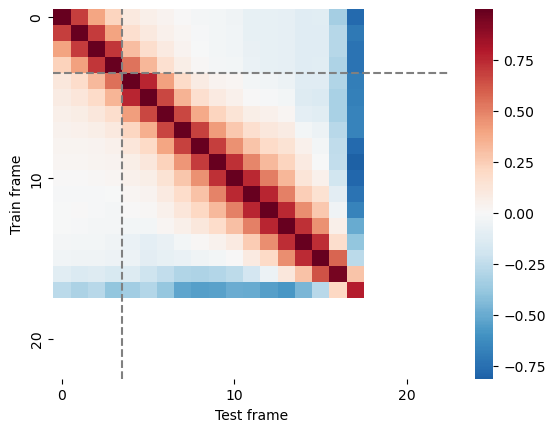

In [23]:
plot_df = temporal_generalization_df.iloc[:30, :30]

ax = sns.heatmap(plot_df, cmap="RdBu_r", center=0, xticklabels=10, yticklabels=10)

assert expand_frame_window[1] == 0
# Draw phoneme onset
if expand_frame_window[0] != 0:
    ax.axvline(expand_frame_window[0], color="gray", linestyle="--")
    ax.axhline(expand_frame_window[0], color="gray", linestyle="--")

ax.set_xlabel("Test frame")
ax.set_ylabel("Train frame")